# EE 445 Final Project: Modeling effectiveness of government response
Nicholas Yama, Spring 2020

## Project goal

At the time of writing (07 May 2020) the United States is beginning to see the number of cases slowing, resulting in increase in desire by a vocal minority to return to normal operations. This would involve the uplifing of wide-scale quarantine and stay-at-home orders that, the evidence indicates has done significant good in slowing the spread of infections. Many arguments are being levied against the effectiveness of these restrictions which are often of dubious scientific merit.

The effectiveness of the government response has varied between states in curbing the number of cases and, due to the lack of national policy from the federal government, will likey be exacerbated as individual states begin to relax these measures. The goal of this project is to model the effectiveness of the government's response at a state level in terms of initial growth rates of the infection.

## Parameters

The number of infected individuals $N$ in its early stages generally can be modeled by an exponential curve

$$N=\exp(r(t-t_0))$$

where $r$ is the growth rate, $t$ is the time, and $t_0$ is the time until the first infection. The growth rate $r$ can then be determined by a linear regression on $\ln(N) = r(t - t_0)$.

This growth rate $r$ will be predicted using a linear regression-type network for the first 6 weeks starting March 1st (a day later the US would reach the first confirmed 100 cases).

The parameters of interest include:
1. The testing rate integrated weekly (so the number of tests administered from March 1 to a given week) normalized by the population (# tests adminstered/population, for 6 weeks).
2. Time from March 1 to declare a "state of emergency"
3. Time from March 1 to close schools and universities
4. Time from March 1 to institute a stay-at-home/quarantine order at a state level.
5. Govenor political affiliation (-1 = republican, 1 = democrat).
6. Population density (control parameter).

When parameters associated with time of response were not achieved within the time frame provided (eg. schools were not closed within the 6 weeks) a value of 50 is assigned.

Each data point will represent an individual state. Only the 50 states and the District of Columbia will be considered, territories of the US such as American Samoa and Puerto Rico will not be used.

## Loading and preprocessing data

In [133]:
import pandas as pd
import numpy as np

In [134]:
url = 'https://raw.githubusercontent.com/nyama8/EE-445-Final-Project/master/testingdata.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [135]:
df

,date,state,positive,negative,tests,time
0,20200412,AK,272.0,7766.0,8038,43
1,20200412,AL,3525.0,18058.0,21583,43
2,20200412,AR,1280.0,18442.0,19722,43
3,20200412,AS,0.0,3.0,3,43
4,20200412,AZ,3539.0,38570.0,42109,43
...,...,...,...,...,...,...
2101,20200302,RI,1.0,NaN,1,2
2102,20200302,WA,34.0,229.0,263,2
2103,20200301,MI,9.0,NaN,9,1
2104,20200301,RI,1.0,NaN,1,1


In [136]:
df.dtypes

date          int64
state        object
positive    float64
negative    float64
tests         int64
time          int64
dtype: object

In [138]:
# Creates dictionary for state abbreviations and applies it to the dataframe
abbrv = []
with open('state_abbrev.txt', 'r') as reader:
    abbrv = reader.read().splitlines()

st_enum = dict([])
for i in range(len(abbrv)):
    st_enum[abbrv[i]] = i

print(st_enum)

df2 = df.replace({'state':st_enum})
num_df = df2.astype({'state' : 'int32'})
num_df.describe()

{'AK': 0, 'AL': 1, 'AR': 2, 'AZ': 3, 'CA': 4, 'CO': 5, 'CT': 6, 'DE': 7, 'FL': 8, 'GA': 9, 'HI': 10, 'IA': 11, 'ID': 12, 'IL': 13, 'IN': 14, 'KS': 15, 'KY': 16, 'LA': 17, 'MA': 18, 'MD': 19, 'ME': 20, 'MI': 21, 'MN': 22, 'MO': 23, 'MS': 24, 'MT': 25, 'NC': 26, 'ND': 27, 'NE': 28, 'NH': 29, 'NJ': 30, 'NM': 31, 'NV': 32, 'NY': 33, 'OH': 34, 'OK': 35, 'OR': 36, 'PA': 37, 'RI': 38, 'SC': 39, 'SD': 40, 'TN': 41, 'TX': 42, 'UT': 43, 'VA': 44, 'VT': 45, 'WA': 46, 'WI': 47, 'WV': 48, 'WY': 49, 'DC': 50, 'AS': 51, 'MP': 52, 'GU': 53, 'PR': 54, 'VI': 55}


,date,state,positive,negative,tests,time
count,2.106000e+03,2106.000000,2091.000000,1963.000000,2106.000000,2106.000000
mean,2.020035e+07,26.978158,2735.374462,13059.403464,14888.545584,24.536562
std,4.158387e+01,15.857036,11890.687767,26479.106277,35791.859537,11.099286
min,2.020030e+07,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.020032e+07,13.000000,17.000000,174.000000,144.000000,15.000000
50%,2.020032e+07,27.000000,194.000000,2989.000000,2433.000000,25.000000
75%,2.020040e+07,41.000000,1239.000000,14030.500000,13990.250000,34.000000
max,2.020041e+07,55.000000,188694.000000,272907.000000,461601.000000,43.000000


In [139]:
#num_df = df.astype({'positive' : 'Int32'})
num_df.dtypes

date          int64
state         int32
positive    float64
negative    float64
tests         int64
time          int64
dtype: object

In [140]:
num_df = num_df[num_df['state'] <= 50]


In [141]:
num_df

,date,state,positive,negative,tests,time
0,20200412,0,272.0,7766.0,8038,43
1,20200412,1,3525.0,18058.0,21583,43
2,20200412,2,1280.0,18442.0,19722,43
4,20200412,3,3539.0,38570.0,42109,43
5,20200412,4,21794.0,168534.0,190328,43
...,...,...,...,...,...,...
2101,20200302,38,1.0,NaN,1,2
2102,20200302,46,34.0,229.0,263,2
2103,20200301,21,9.0,NaN,9,1
2104,20200301,38,1.0,NaN,1,1


In [142]:
# Get final data matrix and convert to numpy array
final_df = num_df.drop(columns=['date', 'negative'])
testing = final_df.to_numpy()

In [145]:
testing = testing.astype(int)
testing

array([[    0,   272,  8038,    43],
       [    1,  3525, 21583,    43],
       [    2,  1280, 19722,    43],
       ...,
       [   21,     9,     9,     1],
       [   38,     1,     1,     1],
       [   46,    30,   111,     1]])

In [148]:
# Re-express data in 51x43 matrix, each row is a particular state, each column a particular day after March 1
cases_by_state = np.zeros([51,43])
for row in testing:
    #print(row)
    try:
        cases_by_state[row[0],row[3]] = row[1]
    except:
        pass
    
    
print(cases_by_state)

[[   0.    0.    0. ...  235.  246.  257.]
 [   0.    0.    0. ... 2769. 2968. 3191.]
 [   0.    0.    0. ... 1119. 1171. 1226.]
 ...
 [   0.    0.    0. ...  523.  554.  577.]
 [   0.    0.    0. ...  230.  253.  261.]
 [   0.    0.    0. ... 1523. 1660. 1778.]]


In [149]:
import matplotlib.pyplot as plt

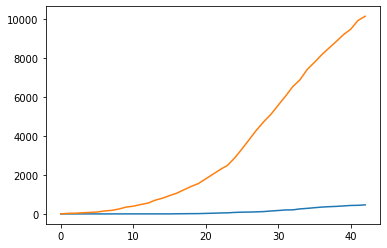

In [151]:
fig, ax = plt.subplots()
ax.plot(range(43), cases_by_state[10], range(43), cases_by_state[46])
plt.show()